In [2]:
# import the required libraries
import numpy as np
import random
import os
import json
import tensorflow.compat.v1 as tf
import keras
from six.moves import xrange

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

# setting for autoreload
%reload_ext autoreload
%autoreload 2

2022-11-29 17:10:56.452055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 17:10:56.582595: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-29 17:10:57.104732: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ndo001/miniconda3/envs/tf/lib/
2022-11-29 17:10:57.104791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugi

In [3]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)
print("Keras Version: ", keras.__version__)

INFO:tensorflow:TensorFlow Version: 2.10.0
Keras Version:  2.10.0


In [4]:
# import command line tools
from sketch_rnn_model import *
from train import *
from utils import *

In [5]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

In [6]:
data_dir = 'data'
model_dir = 'models/owl'

In [7]:
[train_set, valid_set, test_set, hps] = load_env(data_dir, model_dir)

INFO:tensorflow:Loaded 70000/2500/2500 from owl.npz
INFO:tensorflow:Dataset combined: 75000 (70000/2500/2500), avg len 85
INFO:tensorflow:model_params.max_seq_len 250.
total images <= max_seq_len is 70000
total images <= max_seq_len is 2500
total images <= max_seq_len is 2500
INFO:tensorflow:normalizing_scale_factor 42.7029.


In [8]:
model = SketchRNN(hps)
weights = 'models/owl/model_1.hdf5'

2022-11-29 17:11:02.948728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 17:11:02.952804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 17:11:02.952946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 17:11:02.953305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

/home/ndo001/.local/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [9]:
def encode(model, input_strokes):
  strokes = to_big_strokes(input_strokes, max_len=hps.max_seq_len)
  draw_strokes(to_normal_strokes(strokes))
  strokes = np.expand_dims(strokes, axis=0)
  encoder_model = model.encoder
  _, _, z = encoder_model.predict(strokes)
  return z

In [10]:
def decode(model, z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  sample_strokes = sample(model, hps, weights, seq_len=hps.max_seq_len, temperature=temperature,
                          greedy_mode=False, z=z_input)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

In [11]:
# Since sample function clears session every time it runs, 
# you have to run this code to reset the model after sampling.
def reset_model():
  model = SketchRNN(hps)
  model.sketch_rnn_model.load_weights(weights, by_name=True, skip_mismatch=True)
  return model

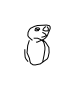

In [12]:
# get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
draw_strokes(stroke)

In [13]:
import h5py
f = h5py.File(weights, 'r')
print(list(f.keys()))
model = reset_model()

['bidirectional_1', 'concatenate_1', 'concatenate_2', 'decoder_input', 'dense_1', 'dense_2', 'dense_4', 'encoder_input', 'lambda_1', 'lstm_2', 'repeat_vector_1']


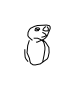

2022-11-29 17:11:05.196569: E tensorflow/stream_executor/cuda/cuda_blas.cc:218] failed to create cublas handle: cublas error
2022-11-29 17:11:05.196596: E tensorflow/stream_executor/cuda/cuda_blas.cc:220] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2022-11-29 17:11:05.196613: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at matmul_op_impl.h:620 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support
2022-11-29 17:11:05.200593: E tensorflow/stream_executor/cuda/cuda_blas.cc:218] failed to create cublas handle: cublas error
2022-11-29 17:11:05.200611: E tensorflow/stream_executor/cuda/cuda_blas.cc:220] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your 

InternalError: Graph execution error:

Detected at node 'encoder/bidirectional_1/backward_lstm_1/while/lstm_cell_6/MatMul_1' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/ndo001/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/ndo001/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 978, in launch_instance
      app.start()
    File "/home/ndo001/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/ndo001/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/ndo001/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/ndo001/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/ndo001/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/ndo001/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/ndo001/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/ndo001/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "/home/ndo001/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/home/ndo001/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/ndo001/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/ndo001/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/ndo001/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_248342/534946297.py", line 1, in <module>
      z = encode(model, stroke)
    File "/tmp/ipykernel_248342/1218462923.py", line 6, in encode
      _, _, z = encoder_model.predict(strokes)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1983, in predict_step
      return self(x, training=False)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/layers/rnn/bidirectional.py", line 277, in __call__
      return super().__call__(inputs, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/layers/rnn/bidirectional.py", line 407, in call
      y_rev = self.backward_layer(
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/layers/rnn/base_rnn.py", line 553, in __call__
      return super().__call__(inputs, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 625, in call
      last_output, outputs, states = backend.rnn(
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/backend.py", line 5139, in rnn
      final_outputs = tf.compat.v1.while_loop(
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/backend.py", line 5118, in _step
      output, new_states = step_function(
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 623, in step
      return self.cell(inputs, states, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 299, in call
      x_f = backend.dot(inputs_f, k_f)
    File "/home/ndo001/.local/lib/python3.10/site-packages/keras/backend.py", line 2455, in dot
      out = tf.matmul(x, y)
Node: 'encoder/bidirectional_1/backward_lstm_1/while/lstm_cell_6/MatMul_1'
Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[{{node encoder/bidirectional_1/backward_lstm_1/while/lstm_cell_6/MatMul_1}}]] [Op:__inference_predict_function_2541]

In [14]:
z = encode(model, stroke)

/home/ndo001/Courses/3A_IA/computer-vision/draft/Sketch-RNN/train.py:106: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  assert FLAGS.weights is not '', 'please set weights file.'
[autoreload of train failed: Traceback (most recent call last):
  File "/home/ndo001/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/ndo001/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/ndo001/Courses/3A_IA/computer-vision/draft/Sketch-RNN/train.py", line 23, in <module>
    tf.app.flags.DEFIN

1/1 [==============================] - 0s 19ms/step


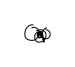

In [ ]:
_ = decode(model, z, temperature=0.2)

Create generated grid at various temperatures from 0.1 to 1.0

1/1 [==============================] - 0s 18ms/step


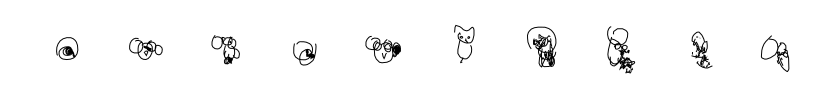

In [ ]:
stroke_list = []
for i in range(10):
  model = reset_model()
  stroke_list.append([decode(model, z, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)

Now interpolate between owl $z_0$ and owl $z_1$

In [ ]:
model = reset_model()

In [ ]:
z0 = z

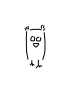

1/1 [==============================] - 0s 18ms/step


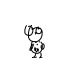

In [ ]:
stroke = test_set.random_sample()
z1 = encode(model, stroke)
_ = decode(model, z1)

In [ ]:
z_list = [] # interpolate between z0 and z1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(lerp(z0, z1, t))

/home/ndo001/Courses/3A_IA/computer-vision/draft/Sketch-RNN/train.py:106: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  assert FLAGS.weights is not '', 'please set weights file.'
[autoreload of train failed: Traceback (most recent call last):
  File "/home/ndo001/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/ndo001/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/ndo001/Courses/3A_IA/computer-vision/draft/Sketch-RNN/train.py", line 23, in <module>
    tf.app.flags.DEFIN

In [ ]:
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  model = reset_model()
  reconstructions.append([decode(model, z_list[i], draw_mode=False, temperature=0.3), [0, i]])

1/1 [==============================] - 0s 16ms/step


In [ ]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

NameError: name 'make_grid_svg' is not defined